In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

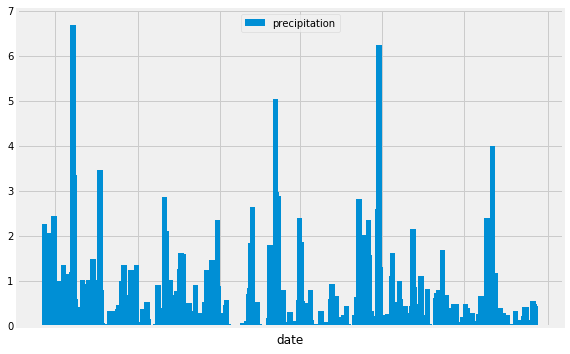

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23')
# for year in last_year:
#     print(year)

# Perform a query to retrieve the data and precipitation scores
last_year_data = pd.DataFrame(last_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_data['date'] = pd.to_datetime(last_year_data.date)

# Sort the dataframe by date
last_year_data.sort_values(by='date')
last_year_data.set_index('date', inplace=True)
# print(last_year_data)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8,5))
plt.bar(last_year_data.index, last_year_data['prcp'], width=4, label="precipitation")
plt.legend(loc='upper center')
plt.xlabel('date')
plt.grid(True)
plt.axes().axes.get_xaxis().set_ticklabels([])
plt.tight_layout(pad = 1)
plt.show()

In [163]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [169]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct()
count=0
for station in stations:
    count+= 1   
print(count)

9


In [176]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for station in stations_count:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [181]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
weather_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281')
for weather in weather_temps:
    print(weather)

(54.0, 85.0, 71.66378066378067)


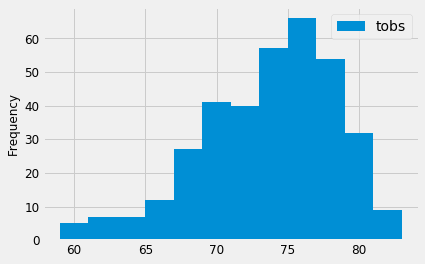

<Figure size 432x288 with 0 Axes>

In [243]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stations_weather = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
# for station in stations_weather:
#     print(station)

weather_data = session.query(Measurement.tobs).filter(Measurement.date > '2016-08-17', Measurement.station == 'USC00519281')
# for weather in weather_data:
#     print(weather)

last_year_temps = pd.DataFrame(weather_data)

temps_chart = last_year_temps.plot(kind='hist', bins=12, fontsize=12) #try bar

temps_chart.set_ylabel("Frequency", fontsize=12)
plt.show()
plt.tight_layout()

# last_year_temps

In [244]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [285]:
trip_weather = calc_temps('2017-06-26','2017-07-10')
trip_weather

[(69.0, 77.91304347826087, 87.0)]

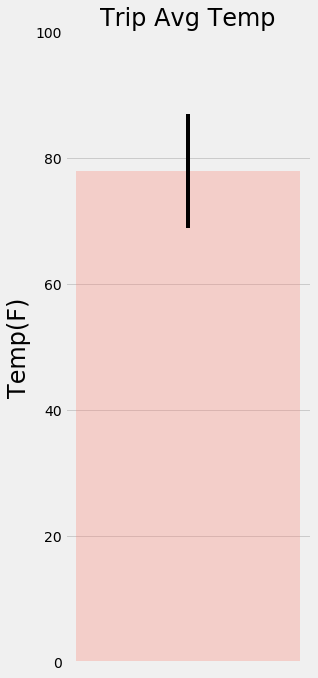

In [356]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,10))
plt.bar(0,trip_weather[0][1], yerr=trip_weather[0][2]-trip_weather[0][1], width=0.01, color='salmon', alpha=0.3)
plt.title('Trip Avg Temp', fontsize=24)
plt.ylabel('Temp(F)', fontsize=24)
plt.xticks([])
plt.ylim(0,100)
plt.tight_layout(pad=2)

In [365]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stations_weather_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).join(Station, Measurement.station == Station.station).filter(Measurement.date >= '2017-06-26').filter(Measurement.date <= '2017-07-10').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
for weather in stations_weather_rain:
    print(weather)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.74)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.85)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.5)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.2)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.09000000000000001)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06)


## Optional Challenge Assignment

In [15]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [73]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date, end_date = '2017-06-26','2017-07-10'

# Use the start and end date to create a range of dates
trip_dates = session.query(Measurement.date).filter(Measurement.date >=start_date, Measurement.date<=end_date).distinct().all() 
# print(trip_dates)


# Strip off the year and save a list of %m-%d strings
trip_days = []
for date in trip_dates:
    month_day = date[0][5:]
    trip_days.append(month_day)
# print(trip_days)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for day in trip_days:
    temps = daily_normals(day)
    normals.append(temps)
normals

[[(67.0, 74.21428571428571, 82.0)],
 [(66.0, 75.01785714285714, 81.0)],
 [(69.0, 74.88679245283019, 80.0)],
 [(67.0, 74.91525423728814, 80.0)],
 [(67.0, 75.59615384615384, 81.0)],
 [(67.0, 74.77777777777777, 81.0)],
 [(68.0, 75.40384615384616, 82.0)],
 [(68.0, 75.32075471698113, 87.0)],
 [(70.0, 76.57142857142857, 81.0)],
 [(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)],
 [(68.0, 75.62068965517241, 82.0)]]

In [92]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_clean = []
for day in trip_dates:
    trip=day[0][0:]
    trip_dates_clean.append(trip)
# print(trip_dates_clean)

mini= []
average =[]
maxi = []
for normal in normals:
    first = normal[0][0]
    sec = normal[0][1]
    third = normal[0][2]
    mini.append(first)
    average.append(sec)
    maxi.append(third)
    
# print(mini)
# print(average)
# print(maxi)

trip_temps = pd.DataFrame(list(zip(mini, average, maxi)), columns=['tmin', 'tavg', 'tmax'], index = trip_dates_clean)

trip_temps

,tmin,tavg,tmax
2017-06-26,67.0,74.214286,82.0
2017-06-27,66.0,75.017857,81.0
2017-06-28,69.0,74.886792,80.0
2017-06-29,67.0,74.915254,80.0
2017-06-30,67.0,75.596154,81.0
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0


Text(0.5, 0, 'date')

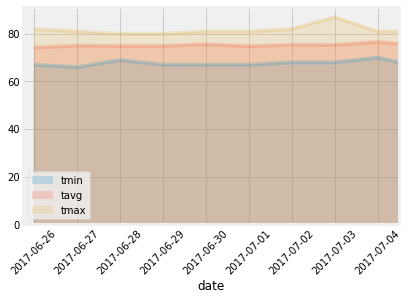

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temps.plot(kind='area', stacked=False, alpha=0.2, rot=45, xlim=(-0.25, 8.5))
plt.xlabel('date')